In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as ExpectedCond
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.firefox.options import Options as FirefoxOptions
from bs4 import BeautifulSoup
import time

# WebDriver Initialization
firefox_prefs = FirefoxOptions()
browser = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=firefox_prefs)

# Website URL
site_url = "https://www.amazon.com/Best-Sellers-Clothing-Shoes-Jewelry-Mens-Fashion-Hoodies-Sweatshirts/zgbs/fashion/1258644011/ref=zg_bs_nav_fashion_3_1040658"
browser.get(site_url)

# Lists to store scraped data
ranking_list = []
item_name_list = []
rating_list = []
reviews_list = []
item_price_list = []

# Scraping loop
while True:
    # Page load wait
    WebDriverWait(browser, 60).until(ExpectedCond.presence_of_element_located((By.ID, "p13n-asin-index-0")))

    for _ in range(10):
        browser.execute_script("window.scrollBy(0, 1000);")
        time.sleep(5)

    page_html = browser.page_source
    parser = BeautifulSoup(page_html, 'html.parser')

    products = parser.find_all('div', attrs={'class': 'a-column a-span12 a-text-center _cDEzb_grid-column_2hIsc'})

    for product in products:
        ranking_elem = product.find('span', attrs={'class': 'zg-bdg-text'})
        ranking_list.append(ranking_elem.get_text() if ranking_elem else '')

        item_elem = product.find('div', attrs={'class': '_cDEzb_p13n-sc-css-line-clamp-3_g3dy1'})
        item_name_list.append(item_elem.get_text() if item_elem else '')

        rating_elem = product.find('span', attrs={'class': 'a-icon-alt'})
        rating_list.append(rating_elem.get_text() if rating_elem else '')

        review_elem = product.find('span', attrs={'class': 'a-size-small'})
        reviews_list.append(review_elem.get_text() if review_elem else '')

        price_elem = product.find('span', attrs={'class': '_cDEzb_p13n-sc-price_3mJ9Z'})
        item_price_list.append(price_elem.get_text() if price_elem else '$0')

    try:
        next_pg_btn = browser.find_element(By.PARTIAL_LINK_TEXT, "Next page")
        next_pg_btn.click()
    except Exception:
        break

# Close the browser
browser.quit()

# Print results
print(item_name_list)
print(ranking_list)
print(rating_list)
print(reviews_list)
print(item_price_list)


C:\Users\PC\AppData\Local\Temp\ipykernel_6720\2284604087.py:13: DeprecationWarning: Firefox will soon stop logging to geckodriver.log by default; Specify desired logs with log_output
  browser = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=firefox_prefs)


["Carhartt Men's Rain Defender Loose Fit Heavyweight Quarter-Zip Sweatshirt", "Amazon Essentials Men's Full-Zip Hooded Fleece Sweatshirt (Available in Big & Tall)", "Carhartt Men's Loose Fit Midweight Logo Sleeve Graphic Sweatshirt", "Carhartt Men's Rain Defender® Loose Fit Heavyweight Sweatshirt", "Amazon Essentials Men's Hooded Fleece Sweatshirt (Available in Big & Tall)", "Amazon Essentials Men's Lightweight French Terry Quarter-Zip Mock Neck Sweatshirt", "Real Essentials 3 Pack: Men's Dry-Fit Active Quarter Zip Long Sleeve Athletic Performance Pullover (Available in Big & Tall)", "Carhartt Men's Loose Fit Midweight Full-Zip Sweatshirt", 'Ohoo Mens Slim Fit Lightweight Zip Up Hoodie with Pockets Long Sleeve Full-Zip Hooded Sweatshirt', "Carhartt Men's Loose Fit Firm Duck Insulated Flannel-Lined Active Jacket", "Amazon Essentials Men's Sherpa-Lined Full-Zip Hooded Fleece Sweatshirt", "Carhartt Men's Rain Defender® Loose Fit Heavyweight Full-Zip Sweatshirt", "Amazon Essentials Men's L

In [22]:
import pandas as pd
import re  # Import the regular expressions library


# Create a dictionary with the scraped data
data = {
    'Rank': ranking_list,
    'Product Name': item_name_list,
    'Average Rating': rating_list,
    'Review Count': reviews_list,
    'Price': item_price_list
}

# Create a Pandas DataFrame from the dictionary
df = pd.DataFrame(data)
# df.to_csv('123output.csv', index=False)

In [26]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


# 1. Clean 'Rank' column
if df['Rank'].dtype == 'object':
    df['Rank'] = df['Rank'].str.replace('#', '').astype(int)
else:
    df['Rank'] = df['Rank'].astype(int)

# 2. Clean 'Average Rating' column
if df['Average Rating'].dtype == 'object':
    df['Average Rating'] = df['Average Rating'].str.extract('(\d+\.\d+)').astype(float)

# 3. Clean 'Review Count' column
df['Review Count'].fillna('0', inplace=True)  # Handling NaN values by replacing them with 0
if df['Review Count'].dtype == 'object':
    df['Review Count'] = df['Review Count'].str.replace(',', '').replace('', '0').astype(int)

# 4. Clean 'Price' column
if df['Price'].dtype == 'object':
    df['Price'] = df['Price'].str.replace('$', '').astype(float)

C:\Users\PC\AppData\Local\Temp\ipykernel_6720\3541132787.py:26: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$', '').astype(float)


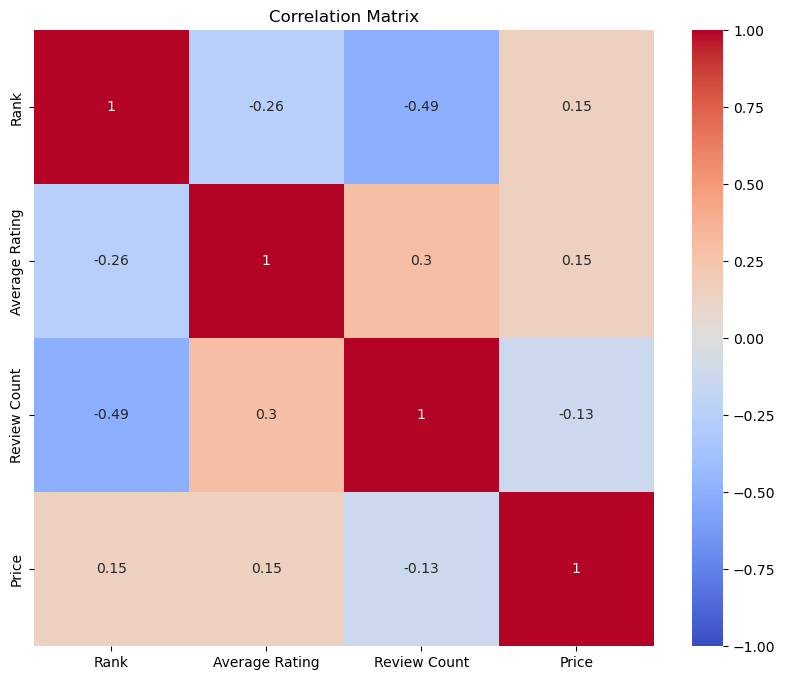

In [27]:
# Drop 'Product Name' column
df = df.drop(columns=['Product Name'])

# Examine Correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()



In [32]:
import pandas as pd
import statsmodels.api as sm
import pandas as pd
import statsmodels.api as sm
import numpy as np 
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Assuming the dataset is loaded as 'parsed_dataset'
# 1. Check for NaN or inf values in independent variables and handle them
for col in ['Average Rating', 'Review Count', 'Price']:
    if df[col].isnull().any() or np.isinf(df[col]).any():
        df[col].fillna(df[col].mean(), inplace=True)  # Replace NaN with mean
        df = df[np.isfinite(df[col])]  # Remove rows with inf values
        
# 1. Is online advertising effective for Star Digital?
X = df[['Average Rating', 'Review Count', 'Price']]
y = df['Rank']
X1 = sm.add_constant(X)  # Adding a constant (intercept) to the model
model1 = sm.OLS(y, X).fit()
print(model1.summary())

# 3. Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

                                 OLS Regression Results                                
Dep. Variable:                   Rank   R-squared (uncentered):                   0.806
Model:                            OLS   Adj. R-squared (uncentered):              0.800
Method:                 Least Squares   F-statistic:                              134.0
Date:                Mon, 02 Oct 2023   Prob (F-statistic):                    2.28e-34
Time:                        04:35:48   Log-Likelihood:                         -466.34
No. Observations:                 100   AIC:                                      938.7
Df Residuals:                      97   BIC:                                      946.5
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------